In [3]:
from typing import List, Tuple, Union
import numpy as np
import datamol as dm
import rdkit.Chem as Chem
import pandas as pd

from posecheck.utils.clashes import count_clashes
from posecheck.utils.loading import load_protein_from_pdb, read_pdbqt, load_mols_from_sdf, load_mols_from_rdkit

from posecheck.utils.strain import get_strain_energy, calculate_energy
from posecheck.utils.interactions import generate_interaction_df
from posecheck.utils.docking import SMINA
from posecheck.utils.constants import EXAMPLE_PDB_PATH, EXAMPLE_LIGAND_PATH

In [8]:
class PoseCheck(object):
    """Main class for PoseCheck.

    Load a protein-ligand complex, check for clashes, strain, interactions, etc.

    Example usage:
    >>> pc = PoseCheck()
    >>> pc.load_protein_from_pdb("data/1a2b.pdb")
    >>> pc.load_ligand_from_sdf("data/1a2b_ligand.sdf")
    # Run posecheck
    >>> pc.check_clashes()
    >>> pc.check_strain()
    >>> pc.check_interactions()
    # Or run all at once
    >>> pc.run()
    """
    def __init__(self, reduce_path: str = "reduce",
                 clash_tolerance: float = 0.5) -> None:
        """Initialize the PoseCheck class.

        Args:
            reduce_path (str, optional): The path to the reduce executable. Defaults to "reduce".
            clash_tolerance (float, optional): The clash tolerance for checking clashes. Defaults to 0.5 A.
        """
        self.reduce_path = reduce_path
        self.clash_tolerance = clash_tolerance


    def load_protein_from_pdb(self, pdb_path: str) -> None:
        """Load a protein from a PDB file.

        Args:
            pdb_path (str): The path to the PDB file.

        Returns:
            None
        """
        self.protein = load_protein_from_pdb(pdb_path, reduce_path=self.reduce_path)

            
    def load_ligands_from_sdf(self, sdf_path: str) -> None:
        """Load a ligand from an SDF file."""
        self.ligands = load_mols_from_sdf(sdf_path)

    def load_ligands_from_pdbqt(self, pdbqt_path: str) -> None:
        """Load a ligand from a PDBQT file."""
        mol = read_pdbqt(pdbqt_path)

        # Save to tmp sdf file and load with Hs
        tmp_path = pdbqt_path.split(".pdbqt")[0] + "_tmp.pdb"
        dm.to_sdfile(mol, tmp_path)
        self.ligands = load_mols_from_sdf(tmp_path)
        os.remove(tmp_path)

    def load_ligands_from_mols(self, mols: List[Chem.Mol], add_hs: bool = True) -> None:
        """Load ligands from a list of RDKit mols.

        Args:
            mols (List[Chem.Mol]): The list of RDKit mol objects representing the ligands.
            add_hs (bool, optional): Whether to add hydrogens to the ligands. Defaults to True.

        Returns:
            None
        """
        self.ligands = load_mols_from_rdkit(mols, add_hs=add_hs)
            
    def load_ligands(self, ligand) -> None:
        """Detect ligand type and load.

        Args:
            ligand (str or Chem.Mol): The ligand to load.

        Raises:
            ValueError: If the ligand type is unknown.

        Returns:
            None
        """
        
        if isinstance(ligand, str):
            if ligand.endswith(".sdf"):
                self.load_ligand_from_sdf(ligand)
            elif ligand.endswith(".pdbqt"):
                self.load_ligand_from_pdbqt(ligand)
            else:
                raise ValueError("Unknown ligand type.")
        elif isinstance(ligand, Chem.Mol):
            self.load_ligand_from_mol(ligand)
        else:
            raise ValueError("Unknown ligand type.")
        
    def calculate_clashes(self) -> int:
        """Calculate the number of steric clashes between protein and ligand."""
        return [count_clashes(self.protein, mol, tollerance=self.clash_tolerance) for mol in self.ligands]

    def calculate_strain_energy(self) -> float:
        """Calculate the strain energy of the ligand."""
        return [get_strain_energy(mol) for mol in self.ligands]
    
    def calculate_interactions(self) -> pd.DataFrame:
        """Calculate the interactions between the protein and the ligand."""
        return generate_interaction_df(self.protein, self.ligands)
    
    def calculate_rmsd(self, mol1: Chem.Mol, mol2: Chem.Mol) -> float:
        """Calculate the RMSD between two molecules
        
        For example, the RMSD between the generated ligand pose and one minimized by docking software.
        """
        return rmsd(mol1, mol2)
    
    def run(self) -> dict:
        """Execute all of PoseCheck suite and return the results.

        This method calculates the clashes, strain energy, and interactions
        between the protein and the ligand. The results are returned as a dictionary.

        Returns:
            dict: A dictionary containing the number of clashes, the strain energy,
                  and the interactions between the protein and the ligand.
        """
        clashes = self.calculate_clashes()
        strain = self.calculate_strain_energy()
        interactions = self.calculate_interactions()
        
        results = {
            "clashes": clashes,
            "strain": strain,
            "interactions": interactions
        }
        return results
    
pc = PoseCheck()
pc.load_protein_from_pdb(EXAMPLE_PDB_PATH)
pc.load_ligands_from_sdf(EXAMPLE_LIGAND_PATH)
#mol =  dm.read_sdf(EXAMPLE_LIGAND_PATH)[0]
#pc.load_ligand_from_mol(mol)

clashes = pc.calculate_clashes()
print(f"Number of clashes: {clashes}")

strain = pc.calculate_strain_energy()
print(f"Strain energy: {strain}")

interactions = pc.calculate_interactions()
print(f'No. of interactions: {interactions}')

Number of clashes: [2]
Strain energy: [19.110000000000007]


100%|██████████| 1/1 [00:00<00:00, 24.91it/s]

No. of interactions: ligand             UNL1                                               \
protein         ARG48.A              HIS175.A    THR180.A   SER185.A   
interaction Hydrophobic VdWContact VdWContact Hydrophobic HBAcceptor   
Frame                                                                  
0                  True       True       True        True       True   

ligand                                                     
protein                   TRP191.A    LEU232.A             
interaction VdWContact Hydrophobic Hydrophobic VdWContact  
Frame                                                      
0                 True        True        True       True  


In [5]:
from prolif.molecule import Molecule
from posecheck.utils.loading import load_sdf_prolif, load_mol_and_add_hs

In [8]:
mol = dm.read_sdf(EXAMPLE_LIGAND_PATH)

In [11]:
import prolif as plf

In [15]:
prot = load_protein_from_pdb(EXAMPLE_PDB_PATH, reduce_path="reduce")

In [21]:
fp = plf.Fingerprint()
fp.run_from_iterable([mol], prot)

100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBDonor', 'HBAcceptor', 'Cationic', 'Anionic', 'PiCation', 'CationPi', 'PiStacking', 'VdWContact'] at 0x2ac183f72610>

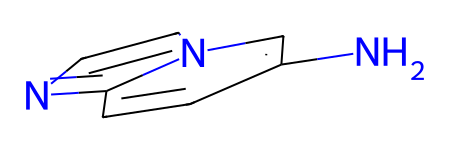

In [19]:
mol

In [18]:
mol = Molecule.from_rdkit(mol[0])

In [22]:
pc.ligand

In [19]:
pc.run()

100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


{'clashes': 2,
 'strain': 19.110000000000007,
 'interactions': ligand             UNL1                                               \
 protein         ARG48.A              HIS175.A    THR180.A   SER185.A   
 interaction Hydrophobic VdWContact VdWContact Hydrophobic HBAcceptor   
 Frame                                                                  
 0                  True       True       True        True       True   
 
 ligand                                                     
 protein                   TRP191.A    LEU232.A             
 interaction VdWContact Hydrophobic Hydrophobic VdWContact  
 Frame                                                      
 0                 True        True        True       True  }